In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE

import seaborn as sns
import shap

# Data analysis

In [155]:
seed = 42

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [156]:
path = "data/credit_card_churn.csv"

In [157]:
df = pd.read_csv(path)

In [158]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [159]:
print("null: \n", df.isna().sum())


null: 
 CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                         

In [160]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['Attrition_Flag'].value_counts())
print("\nimbalance ratio:\n", df['Attrition_Flag'].value_counts(normalize=True))
print(len(df.columns))

duplicates:  0
imbalance count: 
 Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

imbalance ratio:
 Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64
23


# Preprocessing

In [161]:
df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
		"Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", 
		"CLIENTNUM"],
		axis=1, inplace=True)

In [162]:
df["Attrition_Flag"].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [163]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

In [164]:
y = df['Attrition_Flag']
x = df.drop(columns=["Attrition_Flag"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y, shuffle=True)

In [165]:
cat_cols = ["Gender", "Marital_Status"]
ordinal_cols = ["Education_Level", "Card_Category", "Income_Category"]
num_cols = ["Customer_Age", "Dependent_count", "Months_on_book", "Total_Relationship_Count", "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Credit_Limit", "Total_Revolving_Bal", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1", "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", "Avg_Utilization_Ratio"]

In [166]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(x_train[cat_cols])

#Apply on train data
x_train_enc1 = pd.DataFrame(data=ohe.transform(x_train[cat_cols]).toarray(), 
							columns=ohe.get_feature_names_out())

x_train_enc = x_train.copy()

x_train_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_train_enc = pd.concat([x_train_enc.reset_index(drop=True), x_train_enc1], axis=1)

#repeat on test data
x_test_enc1 = pd.DataFrame(data=ohe.transform(x_test[cat_cols]).toarray(),
							columns=ohe.get_feature_names_out())

x_test_enc = x_test.copy()

x_test_enc.drop(columns=cat_cols, axis=1, inplace=True)
x_test_enc = pd.concat([x_test_enc.reset_index(drop=True), x_test_enc1], axis=1)


In [167]:
x_train_enc.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,36,0,Unknown,Less than $40K,Blue,24,4,3,2,2570.0,...,1755,42,0.448,0.868,1.0,0.0,0.0,1.0,0.0,0.0
1,44,3,High School,$60K - $80K,Silver,36,5,2,3,25276.0,...,2282,38,0.583,0.000,0.0,1.0,0.0,0.0,1.0,0.0
2,46,2,High School,$80K - $120K,Blue,30,6,3,1,11670.0,...,4277,89,0.854,0.078,0.0,1.0,0.0,1.0,0.0,0.0
3,36,2,Graduate,Less than $40K,Blue,24,3,1,3,3124.0,...,1652,41,0.367,0.510,1.0,0.0,0.0,1.0,0.0,0.0
4,50,1,Graduate,$120K +,Blue,40,4,2,3,34516.0,...,3874,72,0.714,0.034,0.0,1.0,0.0,0.0,1.0,0.0


In [168]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

for col in categorical_cols:
    print(f"\nValue counts for column: {col}")
    print(df[col].value_counts(dropna=False))


Value counts for column: Gender
Gender
F    5358
M    4769
Name: count, dtype: int64

Value counts for column: Education_Level
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64

Value counts for column: Marital_Status
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64

Value counts for column: Income_Category
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64

Value counts for column: Card_Category
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64


In [169]:
edu_level_enc_order = [
	'Unknown', 
	'Uneducated',	
	'High School',
	'Graduate',
	'College',
	'Doctorate',
	'Post-Graduate'
]

card_cat_order = ["Blue", "Silver", "Gold", "Platinum"]

income_cat_order = [
	'Unknown', 
	'Less than $40K',
	'$40K - $60K',
	'$60K - $80K',
	'$80K - $120K',
	'$120K +',
 ]

In [170]:
#Ordinal encoder on Education 

categories = {
	"Education_Level": edu_level_enc_order,
	"Card_Category": card_cat_order,
	"Income_Category": income_cat_order
}

for cat in ordinal_cols:
	category = categories[cat]

	ord_enc = OrdinalEncoder(categories=[category])
	new_cat_string = f'{cat}_enc'
	x_train_enc[new_cat_string] = ord_enc.fit_transform(x_train_enc.loc[:, [cat]])
	x_test_enc[new_cat_string] = ord_enc.transform(x_test_enc.loc[:, [cat]])

x_train_enc.drop(columns=ordinal_cols, axis=1, inplace=True)
x_test_enc.drop(columns=ordinal_cols, axis=1, inplace=True)


In [171]:
# Drop features that have reduntant information based on other features
x_train_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)

In [172]:
scaler = StandardScaler()
scaler.fit(x_train_enc[num_cols])
x_train_enc[num_cols] = scaler.transform(x_train_enc[num_cols])
x_test_enc[num_cols] = scaler.transform(x_test_enc[num_cols])

In [173]:
smote = SMOTE(random_state=seed)
x_train_enc, y_train = smote.fit_resample(x_train_enc, y_train)

In [174]:
print("\nimbalance ratio:\n", y_train.value_counts(normalize=True))


imbalance ratio:
 Attrition_Flag
0    0.5
1    0.5
Name: proportion, dtype: float64


In [175]:
# Correlation matrix
corr_data = x_train_enc.copy()
corr_data["y"] = y_train
correlation_matrix = corr_data.corr()

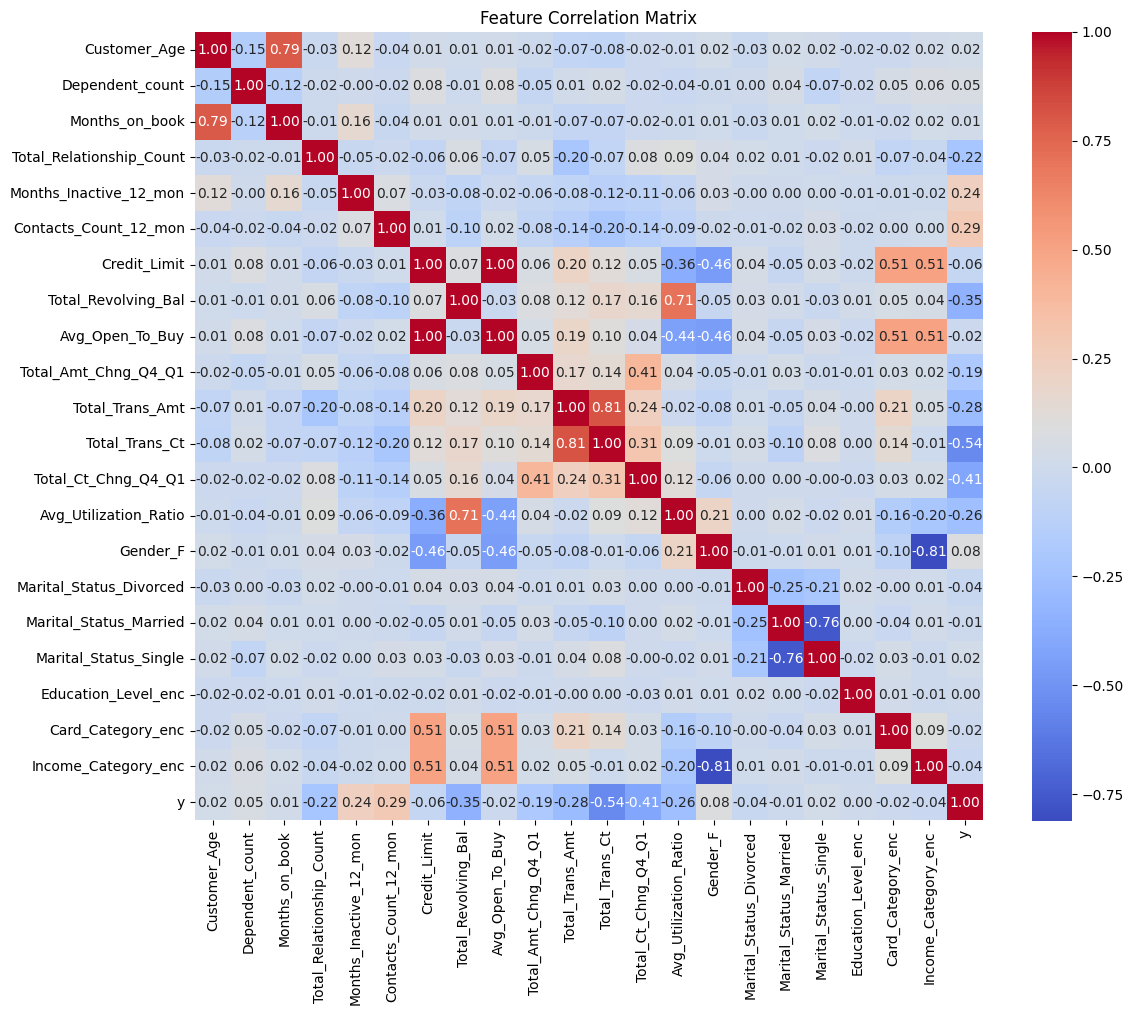

In [176]:
# Compute correlation matrix
correlation_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("pictures/corr_matrix.png")
plt.show()

In [177]:
x_train_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)
x_test_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)

In [178]:
pipe = Pipeline([
	("rf", RandomForestClassifier(class_weight="balanced", random_state=seed, max_depth=8))
])

In [179]:
pipe.fit(x_train_enc, y_train)
y_pred = pipe.predict(x_test_enc)

In [180]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.963376967201059
Test accuracy: 0.9244817374136229
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1701
           1       0.75      0.80      0.77       325

    accuracy                           0.92      2026
   macro avg       0.85      0.87      0.86      2026
weighted avg       0.93      0.92      0.93      2026



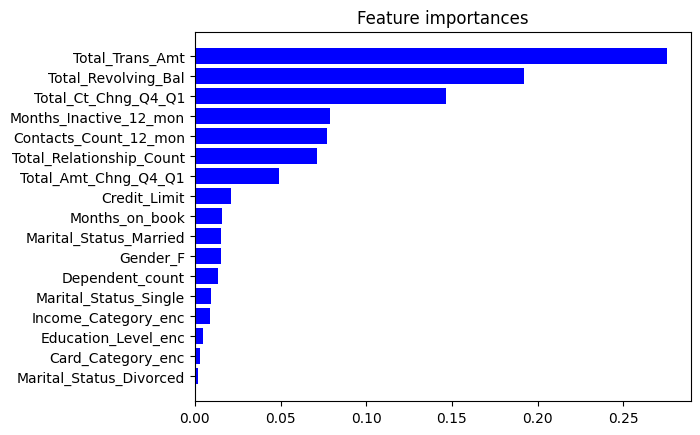

In [181]:
feature_importance = pipe["rf"].feature_importances_
feature_names = x_train_enc.columns

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
plt.savefig("pictures/feat_importances.png")  # high quality
plt.show()

In [182]:
def print_permutation_importances(perm_imp_train, perm_imp_test, cols, plot=False, save_plot=False, save_path="fig.png"):
	print("Train permutation importance ")
	for i, feature in enumerate(cols):
		print(f"- {feature} => Mean: {perm_imp_train.importances_mean[i]:.4f} ; Std: {perm_imp_train.importances_std[i]:.4f}")
	
	print("\n Test permutation importance")
	for i, feature in enumerate(cols):
		print(f"- {feature} => Mean: {perm_imp_test.importances_mean[i]:.4f} ; Std: {perm_imp_test.importances_std[i]:.4f}")
	
	if plot: 
		plt.figure(figsize=(12, 6))

		plt.subplot(1, 2, 1)
		plt.bar(range(len(cols)), perm_imp_train.importances_mean)
		plt.xticks(range(len(cols)), cols, rotation=90)
		plt.title("Permutation Feature Importance in train set")

		plt.subplot(1, 2, 2)
		plt.bar(range(len(cols)), perm_imp_test.importances_mean)
		plt.xticks(range(len(cols)), cols, rotation=90)
		plt.title("Permutation Feature Importance in test set")
		if save_plot:
			plt.savefig(save_path, dpi=300, bbox_inches='tight')  # high quality

		plt.show()

In [183]:
perm_imp_train = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)
perm_imp_test = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

In [209]:
# print_permutation_importances(perm_imp_train, perm_imp_test, x_train_enc.columns, plot=True)

In [185]:
# Removing the 6 least important features
x_train_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level_enc", "Card_Category_enc", "Income_Category_enc"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level_enc", "Card_Category_enc", "Income_Category_enc"], inplace=True)

In [186]:
pipe.fit(x_train_enc, y_train)
y_pred = pipe.predict(x_test_enc)

In [187]:
print(f"Train accuracy: {pipe.score(x_train_enc, y_train)}")
print(f"Test accuracy: {pipe.score(x_test_enc, y_test)}")

report = classification_report(y_true=y_test, y_pred=y_pred)
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy: 0.9634505074275629
Test accuracy: 0.9304047384007897
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.76      0.83      0.79       325

    accuracy                           0.93      2026
   macro avg       0.86      0.89      0.88      2026
weighted avg       0.93      0.93      0.93      2026



In [188]:
perm_imp_train2 = permutation_importance(pipe, x_train_enc, y_train, n_repeats=10, random_state=seed)
perm_imp_test2 = permutation_importance(pipe, x_test_enc, y_test, n_repeats=10, random_state=seed)

In [189]:
# print_permutation_importances(perm_imp_train2, perm_imp_test2, x_train_enc.columns, plot=True)

# Ranking

In [190]:
probs = pipe.predict_proba(x_test_enc)[:, 1]

In [191]:
ranking = probs.argsort()[::-1]
print(ranking)

[1830 1152 1281 ... 1771 1863  176]


In [192]:
# Rank x and y accordingly
x_test_ranked = x_test.iloc[ranking]
y_test_ranked = y_test.iloc[ranking]
probs_ranked = probs[ranking]

In [193]:
# Select top 5
k = 30

x_topk = x_test_ranked.iloc[:k]
y_topk = y_test_ranked.iloc[:k]
probs_topk = probs_ranked[:k]

In [194]:
topk_df = x_topk.copy()
topk_df['true_label'] = y_topk
topk_df['pred_prob'] = probs_topk

topk_df.head(k)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,true_label,pred_prob
3811,49,F,3,Graduate,Single,Unknown,Blue,31,2,3,...,4946.0,0,4946.0,0.540,2239,38,0.407,0.000,1,0.992008
6244,45,F,2,College,Single,Less than $40K,Blue,33,1,3,...,1833.0,0,1833.0,0.549,2037,31,0.292,0.000,1,0.991697
8186,44,F,1,High School,Single,Less than $40K,Blue,36,2,3,...,1895.0,0,1895.0,0.736,2472,40,0.429,0.000,1,0.991581
8084,56,F,3,Unknown,Single,Less than $40K,Blue,39,1,3,...,1632.0,0,1632.0,0.621,2509,47,0.424,0.000,1,0.991557
7253,57,F,3,Graduate,Married,Less than $40K,Blue,45,1,4,...,1759.0,186,1573.0,0.756,2705,35,0.522,0.106,1,0.989197
8044,34,F,2,Graduate,Single,Less than $40K,Blue,36,1,2,...,1666.0,0,1666.0,0.713,2312,35,0.250,0.000,1,0.988998
4177,50,F,1,College,Married,Unknown,Blue,37,2,2,...,1461.0,0,1461.0,0.563,2176,40,0.379,0.000,1,0.988667
5925,55,F,2,Graduate,Divorced,Less than $40K,Blue,50,2,6,...,1720.0,0,1720.0,0.707,2719,36,0.440,0.000,1,0.987993
8120,46,F,4,Doctorate,Single,Less than $40K,Blue,36,2,2,...,2292.0,0,2292.0,0.568,2595,31,0.409,0.000,1,0.987536
6111,39,F,1,Graduate,Married,Less than $40K,Blue,36,1,2,...,1462.0,0,1462.0,0.393,1998,36,0.161,0.000,1,0.985790


# SHAP

In [195]:
id_instance_1 = ranking[0]
id_instance_2 = ranking[29]
class_instance = 1

sample = x_test_enc
masker = shap.maskers.Independent(data=x_test_enc)

explainer = shap.Explainer(model=pipe["rf"].predict_proba, # the function predict_proba
                           masker=masker)

shap_values = explainer.shap_values(sample)

shap_values_instance_1 = shap_values[id_instance_1][:, class_instance]
shap_values_instance_2 = shap_values[id_instance_2][:, class_instance]
print(shap_values_instance_1)
print()
print(shap_values_instance_2)

PermutationExplainer explainer: 2027it [02:06, 14.83it/s]                          

[ 0.00827327  0.00431877  0.11892672  0.04463689  0.05292654  0.00875261
  0.07258499 -0.00526634  0.32242741  0.10851259  0.01115411]

[ 0.00561353  0.00784293 -0.01344942  0.07706892  0.03996454  0.01112667
  0.13309196 -0.00779018  0.37863855  0.07549614  0.0170873 ]


In [196]:
shap_diff = np.subtract(shap_values_instance_1, shap_values_instance_2)
val_diff = np.subtract(x_test_enc.iloc[1], x_test_enc.iloc[24])

prod = shap_diff * val_diff

abs_prod = np.abs(prod) 

sum = np.sum(prod)
print(sum)
print()
print(abs_prod)

0.06820845222903871

Dependent_count             0.004098
Months_on_book              0.007995
Total_Relationship_Count    0.085146
Months_Inactive_12_mon      0.128289
Contacts_Count_12_mon       0.023354
Credit_Limit                0.004591
Total_Revolving_Bal         0.000000
Total_Amt_Chng_Q4_Q1        0.003026
Total_Trans_Amt             0.202864
Total_Ct_Chng_Q4_Q1         0.067213
Gender_F                    0.005933
dtype: float64


# Experiments

In [197]:
# based on perm_imp2
top_5_feat = ["Total_Trans_Amt", "Total_Revolving_Bal", "Total_Relationship_Count", "Total_Ct_Chng_Q4_Q1", "Months_Inactive_12_mon"]

# Experiment 2

In [ ]:
probabilities = []
pre_prob = float(pipe.predict_proba(x_test_enc.iloc[id_instance_2].copy().to_frame().T)[0, 1])

# checks how the probability of sample2 changes when we sample from sample 1, one feature at a time
for col in top_5_feat:
	sample1 =  x_test_enc.iloc[id_instance_1].copy()
	sample2 = x_test_enc.iloc[id_instance_2].copy()

	sample2[col] = sample1[col]
	prob = float(pipe.predict_proba(sample2.to_frame().T)[0, 1])
	probabilities.append((col, prob))

probabilities

[('Total_Trans_Amt', 0.9694513739935237), ('Total_Revolving_Bal', 0.9694513739935237), ('Total_Relationship_Count', 0.9879832850299021), ('Total_Ct_Chng_Q4_Q1', 0.9707209135597462), ('Months_Inactive_12_mon', 0.9694513739935237)]


[np.float64(0.0), np.float64(0.0), np.float64(0.018531911036378412), np.float64(0.001269539566222555), np.float64(0.0)]


/var/folders/dz/r23r91c54xn18t6mjccp7qz40000gn/T/ipykernel_1547/3659275075.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


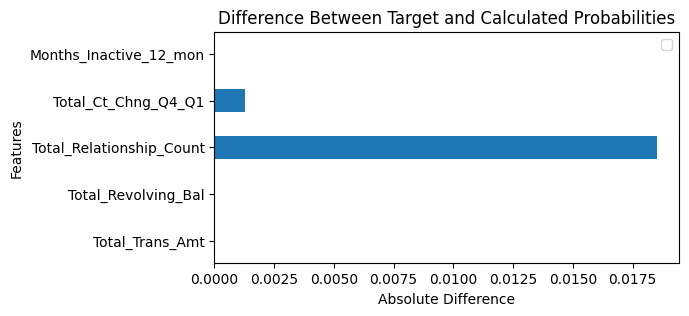

In [ ]:
# Differences
probs = [float(p[1]) for p in probabilities]
labels = [p[0] for p in probabilities]
differences = [np.abs(p - pre_prob) for p in probs]
print(differences)

# Plot
plt.figure(figsize=[6, 3])
plt.barh(range(len(probs)), differences, height=0.5)
plt.title('Difference Between Target and Calculated Probabilities')
plt.ylabel('Features')
plt.yticks(range(len(probs)), labels, rotation=0)
plt.xlabel('Absolute Difference')
plt.legend()
# plt.savefig("pictures/prob_diff.png")
plt.show()